<a href="https://colab.research.google.com/github/nafisenik/NLP-CA2/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import os
import pandas as pd
from itertools import groupby
from operator import itemgetter
import re
from collections import Counter
import numpy as np
import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer



from nltk import regexp_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from string import punctuation
import string
from nltk.tokenize import word_tokenize

import spacy
from spacy import displacy

from nerd import ner

import datetime

In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# a function to read files 
def read_file(file):
    with open(file, 'r', encoding="utf-8") as f:
        text = f.read()
    return text

# set path to text files
file_dir = './Data/Text_Files/'
text_list = []

# find files with .txt and read them
for file in os.listdir(file_dir):
    if file.endswith(".txt"):
        file_path = f'{file_dir}{file}'
        text_list.append(read_file(file_path))

In [4]:
print(f"number of texts: {len(text_list)}")

number of texts: 82


In [5]:
# sample text
print(f"sample text: {text_list[0][:500]}")

sample text: 
Thank you. Mr. Speaker, Mr. Vice President, Members of Congress, my fellow Americans: Tonight marks the eighth year that I've come here to report on the State of the Union. And for this final one, I'm going to try to make it a little shorter. I know some of you are antsy to get back to Iowa. [Laughter] I've been there. I'll be shaking hands afterwards if you want some tips. [Laughter]
Now, I understand that because it's an election season, expectations for what we will achieve this year are low


In [6]:
df = pd.read_csv("./Data/metadata.csv")
df.head()

,Index,President,Categories,Date,Citation,Title
0,0,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 06, 1947","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
1,1,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 07, 1948","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
2,2,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 05, 1949","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
3,3,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 04, 1950","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
4,4,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 08, 1951","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...


#### Change Date Type to datetime

In [7]:
print(df['Title'].dtypes)

object


In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
df['Date']

0    1947-01-06
1    1948-01-07
2    1949-01-05
3    1950-01-04
4    1951-01-08
        ...    
77   2016-01-12
78   2018-01-30
79   2019-02-05
80   2020-02-04
81   2022-03-01
Name: Date, Length: 82, dtype: datetime64[ns]

#### Groupby persidents:
`dict[president_name]` = `[texts]`


In [9]:
president_name = df['President'].tolist()
president_text_dict = {keys: [i for _, i in sub] for keys, sub in groupby(
         zip(president_name, text_list), key = itemgetter(0))}

In [10]:
president_text_dict.keys()

dict_keys(['Harry S. Truman', 'Dwight D. Eisenhower', 'John F. Kennedy', 'Lyndon B. Johnson', 'Richard Nixon', 'Gerald R. Ford', 'Jimmy Carter', 'Ronald Reagan', 'George Bush', 'William J. Clinton', 'George W. Bush', 'Barack Obama', 'Donald J. Trump', 'Joseph R. Biden'])

In [11]:
len(president_text_dict['Barack Obama'])

7

In [12]:
# http://stackoverflow.com/questions/36353125/nltk-regular-expression-tokenizer
pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[a-zA-Z]\.)+(?:[a-zA-Z])?         # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?\s?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''

pattern = re.compile(pattern)

def tokenize_text(text):
    return regexp_tokenize(text, pattern)

In [13]:
def lemmatize_all(sentence):
    l = []
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(tokenize_text(sentence)):
        if tag.startswith('N'):
            l.append(wnl.lemmatize(word, pos='n'))
        elif tag.startswith('V'):
            l.append(wnl.lemmatize(word, pos='v'))
        elif tag.startswith('J'):
            l.append(wnl.lemmatize(word, pos='a'))
        elif tag.startswith('R'):
            l.append(wnl.lemmatize(word, pos='r'))
            
        else:
            l.append(wnl.lemmatize(word, pos='n'))
    return l

In [14]:
sentence_sample = 'The striped bats are  hanging on their feet for best and wrote you are'
print(lemmatize_all(sentence_sample))



['The', 'striped', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best', 'and', 'write', 'you', 'be']


In [15]:
stop_words = set(stopwords.words('english'))
def normalize_and_cleaning(text, lemm=True, remove_punct=True, lower=True, stop_word=True, remove_number=True, min_len = 2):

    text = re.sub(r'(:?\[Laughter\]|\[Applause\]|\[applause\]|\[laughter\])', '', text)
    

    word_tokens = tokenize_text(text)
    
    if lower:
        text = text.lower()
    
    
    if remove_number:
        my_reg = r'\$?\d+\.?\d*\w*\d*'
        text = re.sub(my_reg, '', text)
    
    if remove_punct:
        #text =' '.join([word.strip(punctuation) for word in tokenize_text(text) if len(word) > 1])
        text =' '.join([word.strip(punctuation) for word in tokenize_text(text) if word not in string.punctuation])
    
    if lemm:
      text = ' '.join(lemmatize_all(text))
    
    
    if stop_word:
        text = ' '.join([w for w in tokenize_text(text) if not w.lower() in stop_words])
    

    
    if min_len>1:
        text = ' '.join([word for word in tokenize_text(text) if len(word)>min_len])  

    
    text = re.sub(' +', ' ', text)
    
    return text
    
    

In [16]:
#Test normalize_and_cleaning
test_text ='''[Laughter]poster-print The President. That 1993s Asia—the asia-pacific 22nd 33nd33 6-year U.S.A. wrote good example. [Applause] Well—[applause]. are [Applause] costs $12.40... Michelle Move! u.'''
tokens = tokenize_text(test_text)
res = normalize_and_cleaning(test_text)
res2 = normalize_and_cleaning(test_text,remove_number=False)
print(res)

print(res2)



poster-print president asia asia-pacific year u.s.a write good example well cost michelle move
poster-print president 1993s asia asia-pacific 22nd 33nd33 6-year u.s.a write good example well cost michelle move


In [17]:
all_doc = ' '.join(text_list)
clean_corpuse = normalize_and_cleaning(all_doc)
corpuse_tokens = tokenize_text(clean_corpuse)


In [18]:
counter = Counter(corpuse_tokens)
most_occur = counter.most_common(50)
corpuse_fre_df = pd.DataFrame.from_records(most_occur, columns =['word', 'frequency'])
total_freq = [(x[1]/len(corpuse_tokens))*100 for x in most_occur]
corpuse_fre_df['% total frequency'] = total_freq
corpuse_fre_df

,word,frequency,% total frequency
0,year,3291,1.132855
1,american,2114,0.727698
2,new,2047,0.704635
3,people,1904,0.655410
4,nation,1870,0.643707
5,must,1848,0.636134
6,make,1829,0.629593
7,congress,1828,0.629249
8,program,1773,0.610317
9,world,1747,0.601367


In [19]:
def Statistical_info(text_tokens):
  print (f"Number of words : {len(text_tokens)}")
  print (f"Number of unique  words : {len(set(text_tokens))}")
  word_len_avg = sum(map(len, text_tokens))/float(len(text_tokens))
  print (f"Average word length : {word_len_avg}")
  sent_len_avg = np.mean([len(' '.join(s)) for s in text_tokens])
  max_w = max(text_tokens, key=len)
  min_w = min(text_tokens, key=len)
  print (f"Longest word : {max_w}")
  print (f"Shortest word : {min_w}")

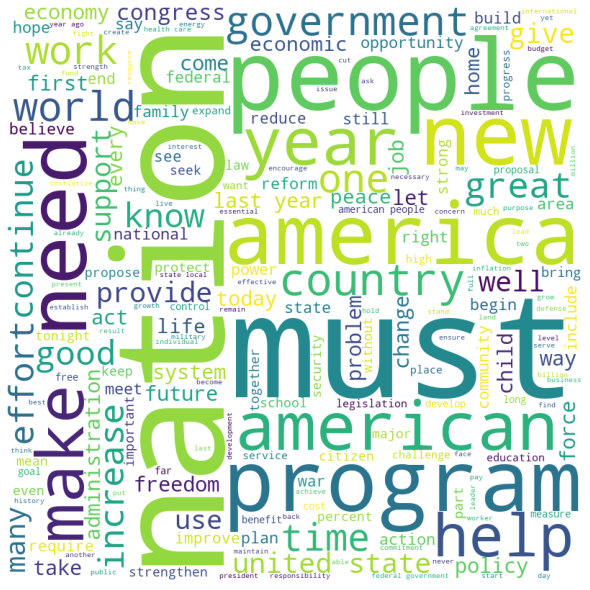

In [20]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(clean_corpuse)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [21]:
  print('*' *50)
  print('Statical information of corpus')
  print('*' *50)
  Statistical_info(corpuse_tokens)

**************************************************
Statical information of corpus
**************************************************
Number of words : 290505
Number of unique  words : 12245
Average word length : 6.419256122958297
Longest word : weapons-of-mass-destruction-related
Shortest word : one


In [22]:
for president, text_list in tqdm.tqdm_notebook(president_text_dict.items()):
  president_texts = (' '.join(text_list))
  clean_text = normalize_and_cleaning(president_texts)
  president_tokens = tokenize_text(clean_text)
  print('*' *50)
  print(president)
  print('*' *50)
  Statistical_info(president_tokens)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/14 [00:00<?, ?it/s]

**************************************************
Harry S. Truman
**************************************************
Number of words : 32942
Number of unique  words : 4734
Average word length : 6.673122457652845
Longest word : employer-employee-government
Shortest word : one
**************************************************
Dwight D. Eisenhower
**************************************************
Number of words : 40940
Number of unique  words : 5066
Average word length : 6.56123595505618
Longest word : reservation-by-reservation
Shortest word : new
**************************************************
John F. Kennedy
**************************************************
Number of words : 11131
Number of unique  words : 2285
Average word length : 5.928757524031983
Longest word : multimillion-dollar
Shortest word : two
**************************************************
Lyndon B. Johnson
**************************************************
Number of words : 14523
Number of unique  words : 2975
A

#### Sentiment Analysis

In [36]:
def sentiment_scores(sentence):
  sentiment_obj = SentimentIntensityAnalyzer()
  sentiment_dict = sentiment_obj.polarity_scores(sentence)
  print("Overall sentiment dictionary is : ", sentiment_dict)
  print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative")
  print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral")
  print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive")
  print("Sentence Overall Rated As", end = " ")
  if sentiment_dict['compound'] >= 0.05 :
      print("Positive")

  elif sentiment_dict['compound'] <= - 0.05 :
      print("Negative")

  else :
      print("Neutral")
  return sentiment_dict

In [38]:
for president, text_list in tqdm.tqdm_notebook(president_text_dict.items()):
  president_texts = (' '.join(text_list))
  clean_text = normalize_and_cleaning(president_texts)
  print('*' *50)
  print(president)
  print('*' *50)
  d = sentiment_scores(clean_text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/14 [00:00<?, ?it/s]

**************************************************
Harry S. Truman
**************************************************
Overall sentiment dictionary is :  {'neg': 0.093, 'neu': 0.637, 'pos': 0.27, 'compound': 1.0}
sentence was rated as  9.3 % Negative
sentence was rated as  63.7 % Neutral
sentence was rated as  27.0 % Positive
Sentence Overall Rated As Positive
**************************************************
Dwight D. Eisenhower
**************************************************
Overall sentiment dictionary is :  {'neg': 0.107, 'neu': 0.624, 'pos': 0.269, 'compound': 1.0}
sentence was rated as  10.7 % Negative
sentence was rated as  62.4 % Neutral
sentence was rated as  26.900000000000002 % Positive
Sentence Overall Rated As Positive
**************************************************
John F. Kennedy
**************************************************
Overall sentiment dictionary is :  {'neg': 0.12, 'neu': 0.627, 'pos': 0.253, 'compound': 1.0}
sentence was rated as  12.0 % Negative
sent

NER

In [23]:
def specify_NER(raw_text):
  doc = ner.name(raw_text, language='en_core_web_sm')
  text_label = [(X.text, X.label_) for X in doc]
  for text, label in text_label:
    raw_text = raw_text.replace(text, label)
  return raw_text

In [24]:
input_text = "That U.S.A. poster-print e.g the U.S costs $12.40 that created in 2008 by Jeff Atwood and Joel Spolsky."
specify_NER(input_text)

'That GPE poster-print e.g the GPE costs $MONEY that created in DATE by PERSON and PERSON.'

In [25]:
NER = spacy.load("en_core_web_sm")
raw_text = 'That U.S.A. poster-print e.g the U.S costs $12.40'
text1= NER(raw_text)
displacy.render(text1,style="ent",jupyter=True)



In [26]:

s = "That U.S.A. and Nicolas poster-print e.g the U.S costs $12.40"
doc = NER(s)
word_tokens = tokenize_text(s)

a = " ".join([t.text if not t.ent_type_ else t.ent_type_ for t in doc])
print(tokenize_text(a))


['That', 'GPE', 'and', 'PERSON', 'poster', '-', 'print', 'e.g', 'the', 'GPE', 'costs', 'MONEY']


In [27]:
l = tokenize_text('That U.S.A. poster-print e.g the U.S costs $12.40 amir. hello')
t = 'That U.S.A. poster-print e.g the U.S costs $12.40 amir. hello'
def punct(text):
    text = ' '.join([t for t in tokenize_text(text) if len(t) > 1])
    text = ' '.join(word.strip(punctuation) for word in tokenize_text(text))
    return text
        
#punct(t) 
import re, string

def test(text):
    out =' '.join([word for word in tokenize_text(text) if word not in string.punctuation])

    return out
print(test(t))
print(punct(t))
#print(l)

That U.S.A. poster-print e.g the U.S costs $12.40  amir hello
That U.S.A poster-print e.g the U.S costs 12.40  amir hello


In [28]:
l = 'That U.S.A. poster-print e.g the U.S costs $12.40 3th amir. hello 7. 9 2th 2nd2 5-year $56 $4 1890'

def remove_num(t):
    my_reg = r'\$?\d+\.?\d*\w*\d*'
    text = re.sub(my_reg, '', t)
    text = re.sub(' +', ' ', text)
    return text

y = remove_num(l)
print(test(y))


That U.S.A. poster-print e.g the U.S costs amir hello year


In [29]:
print(stopwords.words('english'))


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [30]:
from nltk.tokenize import word_tokenize
min_len = 2
l = 'That U.S.A. poster-print e.g the U.S cs $12.40 3th am'
t = word_tokenize(l)
if min_len>1:
    text = ' '.join([word for word in t if len(word)>min_len]) 

In [31]:
text

'That U.S.A. poster-print e.g the U.S 12.40 3th'

In [32]:
text = '[Laughter]poster-print The President. That 1993s [Applause] Asia—the asia-pacific'
tt = re.sub(r'(:?\[Laughter\]|\[Applause\]|\[applause\]|\[laughter\])', '', text)
tt

'poster-print The President. That 1993s  Asia—the asia-pacific'